In [1]:
import os
path = '/home/yash/Desktop/tensorflow-adversarial/tf_example'
os.chdir(path)
# supress tensorflow logging other than errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import numpy as np
import tensorflow as tf
from tensorflow.contrib.learn import ModeKeys, Estimator

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from fgsm4 import fgsm
import mnist

img_rows = 28
img_cols = 28
img_chas = 1
input_shape = (img_rows, img_cols, img_chas)
n_classes = 10

print('\nLoading mnist')
(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.

X_train = X_train.reshape(-1, img_rows, img_cols, img_chas)
X_test = X_test.reshape(-1, img_rows, img_cols, img_chas)

# one hot encoding, basically creates hte si
def _to_categorical(x, n_classes):
    x = np.array(x, dtype=int).ravel()
    n = x.shape[0]
    ret = np.zeros((n, n_classes))
    ret[np.arange(n), x] = 1
    return ret

def find_l2(X_test, X_adv):
    a=X_test.reshape(-1,28*28)
    b=X_adv.reshape(-1,28*28)
    l2_unsquared = np.sum(np.square(a-b),axis=1)
    return l2_unsquared

y_train = _to_categorical(y_train, n_classes)
y_test = _to_categorical(y_test, n_classes)
print('\nShuffling training data')
ind = np.random.permutation(X_train.shape[0])
X_train, y_train = X_train[ind], y_train[ind]

# X_train = X_train[:1000]
# y_train = y_train[:1000]


# split training/validation dataset
validation_split = 0.1
n_train = int(X_train.shape[0]*(1-validation_split))
X_valid = X_train[n_train:]
X_train = X_train[:n_train]
y_valid = y_train[n_train:]
y_train = y_train[:n_train]

class Dummy:
    pass
env = Dummy()




Loading mnist

Shuffling training data


In [2]:
def model(x, logits=False, training=False):
    conv0 = tf.layers.conv2d(x, filters=32, kernel_size=[3, 3],
                             padding='same', name='conv0',
                             activation=tf.nn.relu)
    
    pool0 = tf.layers.max_pooling2d(conv0, pool_size=[2, 2],
                                    strides=2, name='pool0')
    
    conv1 = tf.layers.conv2d(pool0, filters=64,
                             kernel_size=[3, 3], padding='same',
                             name='conv1', activation=tf.nn.relu)
  
    pool1 = tf.layers.max_pooling2d(conv1, pool_size=[2, 2],
                                    strides=2, name='pool1')
    
    flat = tf.reshape(pool1, [-1, 7*7*64], name='flatten')
    dense1 = tf.layers.dense(flat, units=1024, activation=tf.nn.relu,
                            name='dense1')
    dense2 = tf.layers.dense(dense1, units=128, activation=tf.nn.relu,
                            name='dense2')
    logits_ = tf.layers.dense(dense2, units=10, name='logits') #removed dropout
    y = tf.nn.softmax(logits_, name='ybar')
    if logits:
        return y, logits_
    return y

In [3]:
# We need a scope since the inference graph will be reused later
with tf.variable_scope('model'):
    env.x = tf.placeholder(tf.float32, (None, img_rows, img_cols,
                                        img_chas), name='x')
    env.y = tf.placeholder(tf.float32, (None, n_classes), name='y')
    env.training = tf.placeholder(bool, (), name='mode')

    env.ybar, logits = model(env.x, logits=True,
                             training=env.training)

    z = tf.argmax(env.y, axis=1)
    zbar = tf.argmax(env.ybar, axis=1)
    env.count = tf.cast(tf.equal(z, zbar), tf.float32)
    env.acc = tf.reduce_mean(env.count, name='acc')

    xent = tf.nn.softmax_cross_entropy_with_logits(labels=env.y,
                                                   logits=logits)
    env.loss = tf.reduce_mean(xent, name='loss')

extra_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(extra_update_ops):
    env.optim = tf.train.AdamOptimizer(beta1=0.9, beta2=0.999, epsilon=1e-08,).minimize(env.loss) 


In [4]:
with tf.variable_scope('model', reuse=True):
    env.x_adv, env.all_flipped = fgsm(model, env.x, step_size=.05, bbox_semi_side=10) #epochs is redundant now!

In [5]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
sess.run(tf.local_variables_initializer())

In [6]:
def save_model(label):
    saver = tf.train.Saver()
    saver.save(sess,  './models/mnist/' + label)
    
def restore_model(label):
    saver = tf.train.Saver()
    saver.restore(sess, './models/mnist/' + label)

In [7]:
def _evaluate(X_data, y_data, env):
    print('\nEvaluating')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    loss, acc = 0, 0
    ns = 0
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_loss, batch_count, batch_acc = sess.run(
            [env.loss, env.count, env.acc],
            feed_dict={env.x: X_data[start:end],
                       env.y: y_data[start:end],
                       env.training: False})
        loss += batch_loss*batch_size
#         print('batch count: {0}'.format(np.sum(batch_count)))
        ns+=batch_size
        acc += batch_acc*batch_size
    loss /= ns
    acc /= ns
#     print (ns)
#     print (n_sample)
    print(' loss: {0:.4f} acc: {1:.4f}'.format(loss, acc))
    return loss, acc

In [8]:
def _predict(X_data, env):
    print('\nPredicting')
    n_sample = X_data.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    yval = np.empty((X_data.shape[0], n_classes))
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        batch_y = sess.run(env.ybar, feed_dict={
            env.x: X_data[start:end], env.training: False})
        yval[start:end] = batch_y
    return yval

def train(label):
    print('\nTraining')
    n_sample = X_train.shape[0]
    batch_size = 128
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 50
    for epoch in range(n_epoch):
        print('Epoch {0}/{1}'.format(epoch+1, n_epoch))
        for ind in range(n_batch):
            print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
            start = ind*batch_size
            end = min(n_sample, start+batch_size)
            sess.run(env.optim, feed_dict={env.x: X_train[start:end],
                                           env.y: y_train[start:end],
                                           env.training: True})
        if(epoch%5 == 0):
            model_label = label+ '{0}'.format(epoch)
            print("saving model " + model_label)
            save_model(model_label)
            
    save_model(label)
    

In [9]:
def create_adv(X, Y, label):
    print('\nCrafting adversarial')
    n_sample = X.shape[0]
    batch_size = 1
    n_batch = int(np.ceil(n_sample/batch_size))
    n_epoch = 20
    X_adv = np.empty_like(X)
    for ind in range(n_batch):
        print(' batch {0}/{1}'.format(ind+1, n_batch), end='\r')
        start = ind*batch_size
        end = min(n_sample, start+batch_size)
        tmp, all_flipped = sess.run([env.x_adv, env.all_flipped], feed_dict={env.x: X[start:end],
                                             env.y: Y[start:end],
                                             env.training: False})
#         _evaluate(tmp, Y[start:end],env)
        X_adv[start:end] = tmp
#         print(all_flipped)
    print('\nSaving adversarial')
    os.makedirs('data', exist_ok=True)
    np.save('data/mnist/' + label + '.npy', X_adv)
    return X_adv

In [10]:
label = "mnist_with_cnn"
# train(label) # else 
#Assuming that you've started a session already else do that first!
restore_model(label + '50')
# restore_model(label + '10')
# restore_model(label + '50')
# restore_model(label + '100')
print("Train acc: ")
_evaluate(X_train, y_train, env)
print("Test acc: ")
_evaluate(X_test, y_test, env)

INFO:tensorflow:Restoring parameters from ./models/mnist/mnist_with_cnn50
Train acc: 

Evaluating
 loss: 0.0018 acc: 0.9998
Test acc: 

Evaluating
 loss: 0.0592 acc: 0.9924


(0.059236754475852318, 0.99238528481012656)

In [11]:
def random_normal_func(X, n):
    X=X.reshape(-1,img_rows*img_cols*img_chas)
    print(X.shape)
    mean, std = np.mean(X, axis=0), np.std(X,axis=0)
    randomX = np.zeros([n,X[0].size])
    print(randomX.shape)
    for i in range(X[0].size):
        randomX[:,i] = np.random.normal(mean[i],std[i],n)
    randomX = randomX.reshape(-1,img_rows,img_cols,img_chas)
    ans = sess.run(env.ybar, feed_dict={env.x: randomX,env.training: False})
    labels = _to_categorical(np.argmax(ans,axis=1), n_classes)
    return randomX,labels
    

In [12]:
test = "test_fs_exp1_50"
train = "train_fs_exp1_50"
random = "random_fs_exp1_50"
random_normal= "random_normal_fs_exp1_50"


n = 1000
X_train_sub = X_train[:n]
y_train_sub = sess.run(env.ybar, feed_dict={env.x: X_train_sub,env.training: False})
y_train_sub = _to_categorical(np.argmax(y_train_sub, axis=1), n_classes)

y_test_sub = sess.run(env.ybar, feed_dict={env.x: X_test[:n],env.training: False})
y_test_sub = _to_categorical(np.argmax(y_test_sub, axis=1), n_classes)

X_random = np.random.rand(n,28,28,1)
X_random = X_random[:n]
y_random = sess.run(env.ybar, feed_dict={env.x: X_random,env.training: False})
y_random = _to_categorical(np.argmax(y_random, axis=1), n_classes)
X_random_normal, y_random_normal = random_normal_func(X_train,n)

X_adv_test = create_adv(X_test[:n], y_test_sub, test)
X_adv_train = create_adv(X_train_sub, y_train_sub, train)
X_adv_random = create_adv(X_random,y_random, random)
X_adv_random_normal = create_adv(X_random_normal, y_random_normal, random_normal)

# X_adv_test = np.load('data/mnist/' + test + '.npy')
# X_adv_train = np.load('data/mnist/' + train + '.npy')
# X_adv_random = np.load('data/mnist/' + random + '.npy')
# X_adv_random_normal = np.load('data/mnist/' + random_normal + '.npy')

(54000, 784)
(1000, 784)

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial

Crafting adversarial
 batch 1000/1000
Saving adversarial


In [13]:
l2_test = find_l2(X_adv_test,X_test[:n])
l2_train = find_l2(X_adv_train, X_train_sub)
l2_random = find_l2(X_adv_random,X_random)
l2_random_normal = find_l2(X_adv_random_normal,X_random_normal)

In [17]:
print (np.count_nonzero(l2_test))
print (np.count_nonzero(l2_train))

514
433


In [15]:
print(X_adv_random_normal[0][3])

[[  3.43225861e-06]
 [  8.42813606e-05]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  6.87224139e-03]
 [  7.71316327e-03]
 [  3.50497514e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  4.92717847e-02]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  1.80913182e-03]
 [  2.14390904e-01]
 [  1.08349591e-01]
 [  0.00000000e+00]
 [  1.05175473e-01]
 [  1.29324034e-01]
 [  2.12986004e-02]
 [  0.00000000e+00]
 [  1.25010595e-01]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  8.38372856e-03]
 [  0.00000000e+00]
 [  0.00000000e+00]
 [  0.00000000e+00]]


ValueError: x and y must have same first dimension, but have shapes (10000,) and (1000,)

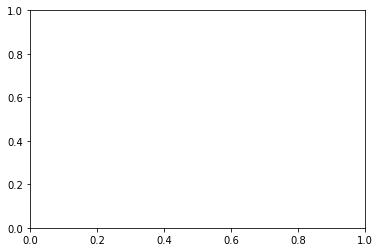

In [16]:
%matplotlib inline
# evenly sampled time at 200ms intervals
t = np.arange(1,10001, 1)

# red dashes, blue squares and green triangles
plt.plot(t, l2_test, 'r--', t, l2_train, 'b--', t, l2_random, 'y--', l2_random_normal, 'g--')
plt.show()

In [ ]:
import matplotlib.patches as mpatches

%matplotlib inline
# evenly sampled time at 200ms intervals
t = np.arange(1,101, 1)

# red dashes, blue squares and green triangles
plt.plot(t, l2_test[:100], 'r--', t, l2_train[:100], 'b--',t, l2_random[:100], 'y--',l2_random_normal[:100], 'g--')
blue_patch = mpatches.Patch(color='blue', label='Train Data')
plt.legend(handles=[blue_patch])

plt.show()

In [ ]:
%matplotlib inline
plt.hist(l2_test,100)
plt.title("L2 distance of test data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [ ]:
%matplotlib inline
plt.hist(l2_train,100)
plt.title("L2 distance of train data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [ ]:
%matplotlib inline
plt.hist(l2_random,100)
plt.title("L2 distance of random data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()

In [ ]:
%matplotlib inline
plt.hist(l2_random_normal,100)
plt.title("L2 distance of random normal data")
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.show()